# **IMPORT LIBS**

In [7]:
import warnings

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam


import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import keras.backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from skimage.transform import rotate, shear, zoom
#from imgaug import augmenters as iaa

warnings.filterwarnings('ignore')

In [8]:
# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/train&test'):
    os.makedirs('runtime_saves/train&test')
    
current_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir, os.pardir))

datasetUAH_dir = os.path.join(root_dir, 'datasets', 'UAH-DRIVESET-v1', 'UAH-Processed')

print(f'Root directory: {root_dir}')
print(f'Dataset directory: {datasetUAH_dir}')

Root directory: c:\codeUni\ProjetoInformatico\aaa\CoEProject-AI-DrivingClassification
Dataset directory: c:\codeUni\ProjetoInformatico\aaa\CoEProject-AI-DrivingClassification\datasets\UAH-DRIVESET-v1\UAH-Processed


# **AUX FUNCTIONS**

In [9]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  
  filename = 'runtime_saves/' + filename
    
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')



def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

def has_one(data):
  """
  This function receives a numpy array and returns a new array
  with 1 if the correspondent row of input array has at least one cellule with 1.
  In other case the cellule is 0.

  Args:
      data: A numpy array of shape (n, 12) with 0 or 1 values in each cell.

  Returns:
      A numpy array of shape (n, 1) with 1s where the corresponding row in data has at least one 1, and 0s otherwise.
  """
  # We sum each row, and any value greater than zero indicates at least one 1 in that row
  return np.sum(data, axis=1)[:, np.newaxis] > 0

# **IMPORT DATA**

In [10]:
dataset = os.path.join(os.getcwd(), os.pardir, 'docs', 'v2', 'dataset-all.csv')
# dataset = os.path.join(os.getcwd(), os.pardir, 'docs', 'v1', 'Abrantes-Leiria.csv')


df = pd.read_csv(dataset)

acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

In [11]:
print(df['accelerometerXAxis'].describe())
print(df['accelerometerYAxis'].describe())
print(df['accelerometerZAxis'].describe())
print(df['gyroscopeXAxis'].describe())
print(df['gyroscopeYAxis'].describe())
print(df['gyroscopeZAxis'].describe())

count    150070.000000
mean          0.001342
std           1.264318
min         -11.536232
25%          -0.547894
50%           0.005779
75%           0.559436
max          14.109398
Name: accelerometerXAxis, dtype: float64
count    150070.000000
mean          0.055583
std           0.932284
min         -13.825549
25%          -0.397755
50%           0.042851
75%           0.495079
max          11.939904
Name: accelerometerYAxis, dtype: float64
count    150046.000000
mean          0.087325
std           1.411255
min         -20.017138
25%          -0.612250
50%           0.050575
75%           0.742957
max          16.155849
Name: accelerometerZAxis, dtype: float64
count    150070.000000
mean          0.000406
std           0.099782
min          -2.247918
25%          -0.040928
50%          -0.000305
75%           0.040317
max           2.192789
Name: gyroscopeXAxis, dtype: float64
count    150070.000000
mean          0.004894
std           0.172807
min          -2.713842
25%         

# **SEPARATE DATA BY MANOVER**

In [12]:
turnRightX, turnLeftX = separate_positives_negatives(acelX)

accelY, breakY = separate_positives_negatives(acelY)

positiveZ, negativeZ = separate_positives_negatives(acelZ)

gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)
gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)
gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)

In [13]:
turnRightX.shape

(150070,)

# **CLASSIFICATION BASED ON NOT NORMALIZED VALUES**

In [14]:
#x1 = np.array(list(zip(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ, gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)))

#y = y_classification(x1, 0.25)
#print (np.sum(y, axis=0))
#np.savetxt("Y.csv", y, delimiter=',', fmt='%.0i')

# **NORMALIZE DATA**

In [15]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

# **CREATE AN ARRAY WITH ALL DATA**

In [16]:
x = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

In [17]:
x.shape

(150070, 12)

In [18]:
y = y_classification(x, 0.3)
print (np.sum(y, axis=0))

filename = 'runtime_saves/' + 'Y.csv'
print(y)

np.savetxt(filename, y, delimiter=',', fmt='%.0i')

[ 789 2127  408  247  896  191   45   30   10  142   88    6]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# **SHOW MANOVERS ON GOOLGE MAP**

In [19]:
positions = np.array(list(zip(latitude, longitude)))
manover_accelY = y[:, 2]
manover_breakY = y[:, 3]
manover_turnRightXn = y[:, 0]
manover_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, manover_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, manover_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, manover_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, manover_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

# **PLOT MANOVERS**

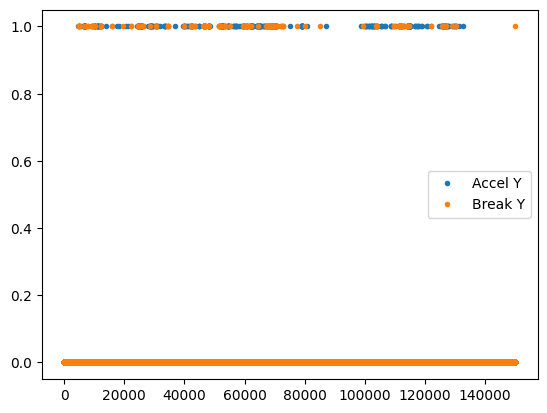

In [20]:
plt.plot(y[:, 2], marker='.', linestyle='none')
plt.plot(y[:, 3], marker='.', linestyle='none')

plt.legend(['Accel Y', 'Break Y'])
plt.show()

# **SEPARATE DATA IN TRAIN AND TEST**

In [21]:
x_train, x_test = split_train_test(x, test_size=0.2)

y_train, y_test = split_train_test(y, test_size=0.2)

# **CREATE THE INPUT TENSORES DATA**

In [22]:
train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

print(train.shape)
print(test.shape)

np.savetxt("runtime_saves/train&test/x_train.csv", x_train, delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/x_test.csv", x_test, delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/y_train.csv", y_train, delimiter=',', fmt='%.0i')
np.savetxt("runtime_saves/train&test/y_test.csv", y_test, delimiter=',', fmt='%.0i')

np.savetxt("runtime_saves/train&test/train.csv", train.reshape(train.shape[0], train.shape[2]), delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/test.csv", test.reshape(test.shape[0], test.shape[2]), delimiter=',', fmt='%.9f')

(120056, 1, 12)
(30014, 1, 12)


# **CREATE THE MODEL**

In [23]:
K.clear_session()

dropout = 0.01
# learning_rate = 0.001

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, train.shape[2]), return_sequences=True))
model_lstm.add(Dropout(dropout))
model_lstm.add(Dense(32,activation='relu'))        
model_lstm.add(Dense(1,activation='sigmoid'))

# Compile the model
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# **TRAIN THE MODEL**

In [24]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model
model_lstm_output = model_lstm.fit(train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/30


3002/3002 [==============================] - 10s 3ms/step - loss: 0.0316 - accuracy: 0.9967 - val_loss: 0.0183 - val_accuracy: 0.9960 - lr: 0.0010
Epoch 2/30
3002/3002 [==============================] - 7s 2ms/step - loss: 0.0130 - accuracy: 0.9971 - val_loss: 0.0178 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 3/30
3002/3002 [==============================] - 8s 3ms/step - loss: 0.0123 - accuracy: 0.9971 - val_loss: 0.0169 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 4/30
3002/3002 [==============================] - 8s 3ms/step - loss: 0.0119 - accuracy: 0.9971 - val_loss: 0.0168 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 5/30
3002/3002 [==============================] - 8s 3ms/step - loss: 0.0116 - accuracy: 0.9971 - val_loss: 0.0160 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 6/30
3002/3002 [==============================] - 8s 3ms/step - loss: 0.0114 - accuracy: 0.9971 - val_loss: 0.0156 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 7/30
3002/3002 [==============================] -

# **SHOW THE RESULTS**

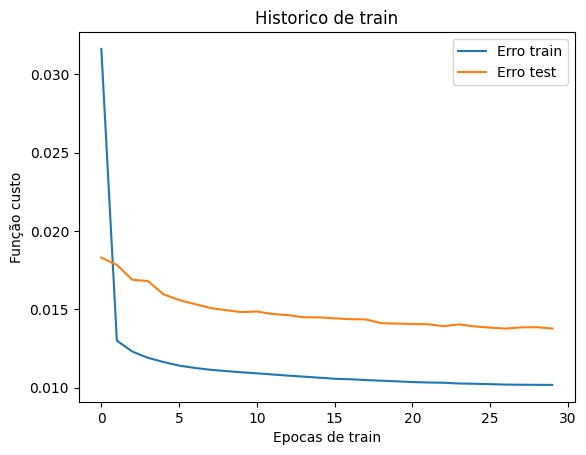

In [25]:
plt.plot(model_lstm_output.history['loss'])
plt.plot(model_lstm_output.history['val_loss'])
plt.title('Historico de train')
plt.xlabel('Epocas de train')
plt.ylabel('Função custo')
plt.legend(['Erro train', 'Erro test'])
plt.show()

In [26]:
accuracy = model_lstm.evaluate(test, y_test)[1]  # Assuming accuracy is the second metric
print('Test Accuracy:', accuracy)

938/938 [==============================] - 1s 1ms/step - loss: 0.0054 - accuracy: 0.9985
Test Accuracy: 0.9985061883926392


# **TEST THE NETWORK**

In [27]:
loss, accurary = model_lstm.evaluate(test, y_test, batch_size=16)
print('Test loss/accurary:', loss, accurary)


1876/1876 [==============================] - 2s 1ms/step - loss: 0.0054 - accuracy: 0.9985
Test loss/accurary: 0.005414588842540979 0.9985063076019287


## **Confusion Matrix**

In [28]:
# y_pred = model_lstm.predict(treino)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Plot confusion matrix
# cm = confusion_matrix(y_treino, y_pred_classes)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Matriz de Confusão')
# plt.show()

# # Additional debugging: Print training history
# print(history.history)

In [29]:
test[0]
test.shape

(30014, 1, 12)

In [30]:
i = 0
for i in range(100):
    a = x_test[i]
    b = a.reshape(1, 1, 12)

    # Make predictions on new data
    prediction = model_lstm.predict(b)
    #predicted_class = label_encoder.inverse_transform(prediction)[0]

    np.round(prediction, decimals=1, out=prediction)
    np.round(x_test[i], decimals=1, out=x_test[i])
    #print("Value:", newArray[i + start])
    if (np.sum(y_test[i]) > 0):
      print("X [:", x_test[i])
      print("Y [:", y_test[i])
      print("PC:", prediction)
      print (i)
    i = 1 + 1
#PREDICTIONS WITH COLAB MODEL
#prediction = model.predict(teste)
#print("Predicted class:", prediction)
#print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 21ms/step
X [: [0.  0.2 0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
Y [: [0 1 0 0 0 0 0 0 0 0 0 0]
PC: [[[0.]]]
88
1/1 [==============================] - 0s 19ms/step


In [31]:
test_value = np.array([0., 0.363, 0.313, 0., 0., 0.31, 0.393, 0., 0., 0.244, 0.247, 0.])
test_value = test_value.reshape(1, 1, 12)

# Make predictions on new data
prediction = model_lstm.predict(test_value)
np.round(prediction, decimals=2, out=prediction)

print("Value    :", test_value[0][0])
print("Predicted:", prediction[0])

1/1 [==============================] - 0s 18ms/step
Value    : [0.    0.363 0.313 0.    0.    0.31  0.393 0.    0.    0.244 0.247 0.   ]
Predicted: [[0.31]]


# **SAVE THE MODEL**

In [32]:
import os
import datetime

model_name = 'lstm_model_' + datetime.datetime.now().strftime("%Y-%m-%d %HH%Mm%Ss") + '.h5'

# Save the model in runtime_saves/models folder
model_lstm.save(os.path.join(".", 'runtime_saves', 'models', model_name))

In [33]:
# model sumary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             12600     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 dense (Dense)               (None, 1, 32)             1632      
                                                                 
 dense_1 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 14265 (55.72 KB)
Trainable params: 14265 (55.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
